# Ensemble optimization

This notebook is an example on how to perform an ensemble optimization. It closly follows the procedure described in  
>['Goerz et al. *Physical Review A 90*, 032329 (2014)'](https://doi.org/10.1103/PhysRevA.90.032329)

The main goal is to present a robust optimization of the two-quibt gate in a system with two coupled Rydberg qubits. This is achived by using ensemble optimization, which is desribed in more detail [below](#Optimization-with-ensembles).

In [1]:
# NBVAL_IGNORE_OUTPUT
%load_ext watermark
import qutip
import numpy as np
import scipy
import matplotlib
import matplotlib.pylab as plt
%watermark -v --iversions

matplotlib.pylab 1.15.4
matplotlib       3.0.2
numpy            1.15.4
scipy            1.2.0
qutip            4.3.1
CPython 3.6.8
IPython 7.2.0


In [2]:
import krotov
import itertools

$\newcommand{tr}[0]{\operatorname{tr}}
\newcommand{diag}[0]{\operatorname{diag}}
\newcommand{abs}[0]{\operatorname{abs}}
\newcommand{pop}[0]{\operatorname{pop}}
\newcommand{aux}[0]{\text{aux}}
\newcommand{opt}[0]{\text{opt}}
\newcommand{tgt}[0]{\text{tgt}}
\newcommand{init}[0]{\text{init}}
\newcommand{lab}[0]{\text{lab}}
\newcommand{rwa}[0]{\text{rwa}}
\newcommand{bra}[1]{\langle#1\vert}
\newcommand{ket}[1]{\vert#1\rangle}
\newcommand{Bra}[1]{\left\langle#1\right\vert}
\newcommand{Ket}[1]{\left\vert#1\right\rangle}
\newcommand{Braket}[2]{\left\langle #1\vphantom{#2} \mid #2\vphantom{#1}\right\rangle}
\newcommand{op}[1]{\hat{#1}}
\newcommand{Op}[1]{\hat{#1}}
\newcommand{dd}[0]{\,\text{d}}
\newcommand{Liouville}[0]{\mathcal{L}}
\newcommand{DynMap}[0]{\mathcal{E}}
\newcommand{identity}[0]{\mathbf{1}}
\newcommand{Norm}[1]{\lVert#1\rVert}
\newcommand{Abs}[1]{\left\vert#1\right\vert}
\newcommand{avg}[1]{\langle#1\rangle}
\newcommand{Avg}[1]{\left\langle#1\right\rangle}
\newcommand{AbsSq}[1]{\left\vert#1\right\vert^2}
\newcommand{Re}[0]{\operatorname{Re}}
\newcommand{Im}[0]{\operatorname{Im}}$

## Model

### One qubit Hamiltonian

The qubits are realized in two hyperfine levels of a cesium atom. In addition to that, we also have an intermediate and a Rydberg level. The levels are depicted below:
<center><img src="https://journals.aps.org/pra/article/10.1103/PhysRevA.90.032329/figures/1/medium" width="300"/></center>

<center>This is Fig. 1 from the publication.</center>





We use qutip to get the individual states and the unity matrix for one qubit, which will be frequently used:

In [3]:
rydberg = qutip.basis(4,3)    # Rydberg level |r>
intermd = qutip.basis(4,2)    # intermediate level |i>
qb_excited = qutip.basis(4,1) # qubit excited state |1>
qb_ground = qutip.basis(4,0)  # qubit ground state |0>

unity_1q = qutip.qeye(4)

Now we set up the parameters and construct the Hamiltonian according to the paper:

\begin{align*}
\hat{\mathcal{H}}_{\mathrm{1q}} &=  \begin{pmatrix}
0 & 0 & \Omega_{\mathrm{B}}(t) & 0 \\
0 & E_1 & 0 & 0 \\
\Omega_{\mathrm{B}}(t) & 0 & \Delta_1 & \Omega_{\mathrm{R}}(t) \\
0 & 0 & \Omega_{\mathrm{R}}(t) & \Delta_2 
\end{pmatrix} \\
&= \Omega_{\mathrm{B}}(t)\bigg( \ket{0}\bra{i} + \ket{i}\bra{0} \bigg) \ 
        + \ \Omega_{\mathrm{R}}(t)\bigg( \ket{r}\bra{i} + \ket{i}\bra{r} \bigg) \ 
        + \ \text{diag}(0,E_1,\Delta_1,\Delta_2) 
\end{align*}

To account for the decay of the intermediate level, we add a coefficient $-\frac{i\gamma}{2}$, with $\gamma=\frac{1}{\tau}>0$ to the intermediate level, leading to a non hermitian Hamiltonian (also c.f. [the notebook on the lambda system with non hermitian Hamiltonian](03_example_lambda_system_rwa_non_hermitian.ipynb)).
To penalize the decay even further, we increase the decay value by a factor of 100:

\begin{align*}
\hat{\mathcal{H}}_{\mathrm{1q}} &=  \begin{pmatrix}
0 & 0 & \Omega_{\mathrm{B}}(t) & 0 \\
0 & E_1 & 0 & 0 \\
\Omega_{\mathrm{B}}(t) & 0 & \Delta_1-\frac{100i\gamma}{2} & \Omega_{\mathrm{R}}(t) \\
0 & 0 & \Omega_{\mathrm{R}}(t) & \Delta_2 
\end{pmatrix} 
\end{align*}

In [4]:
# Rabi frequency blue
Ω_blue = 1#171.5e-3 # in GHz

# Rabi frequency red
Ω_red = 1#148.4e-3 # in GHz

# Diagonal
## eigenenergies of the qubits
E0   = 0     # in GHz
E1   = 9.100 # in GHz
## one-/two-photon detuning
Δ1   = 1.273 # in GHz
Δ2   = 0     # in GHz

# decay time (in ns)
τ = 150.0 

In [5]:
def get_1q_hams(rabi_freq_blue=Ω_blue, rabi_freq_red=Ω_red, 
                diag=[E0,E1,Δ1,Δ2], γ=1./τ                   
                ):
    
    blue_driving_hamiltonian = rabi_freq_blue * (qb_ground*intermd.dag() + intermd*qb_ground.dag())
    red_driving_hamiltonian = rabi_freq_red * (rydberg*intermd.dag() + intermd*rydberg.dag())
     
    # adding diagonal + dissipation   
    eigen_ham = qutip.qdiags(diag, 0) #+ qutip.qdiags([0,0,-100*.5j*γ,0], 0)
        
    return eigen_ham, blue_driving_hamiltonian, red_driving_hamiltonian

### Two qubit Hamiltonian

We define the controls for the left atom and compose the left and right atom single qubit Hamiltonian:
\begin{align}
    \op{\mathcal{H}}_{\text{1q}}^{\ \text{left }} &= \op{\mathcal{H}}_{\text{1q}} \otimes \mathbb{1} & 
    \op{\mathcal{H}}_{\text{1q}}^{\ \text{right}} &= \mathbb{1} \otimes \op{\mathcal{H}}_{\text{1q}}
\end{align}

and combine them to the two qubit Hamiltonian

\begin{equation}
    \op{\mathcal{H}}_{\text{2q}} = \op{\mathcal{H}}_{\text{1q}}^{\ \text{right}} 
                                       + \op{\mathcal{H}}_{\text{1q}}^{\ \text{left}}
                                       - u \ket{rr}\bra{rr} 
\end{equation}


In [6]:
rydberg_coupling = 57.26e-3 # in GHz

def get_ham_2q(u=rydberg_coupling, **kwargs):
    """  """
    
    rr_ket = qutip.tensor(rydberg,rydberg)
    rr_rr_ineraction = u * rr_ket*rr_ket.dag()
    
    #Get one qubit Hamiltonian
    eigen_ham_l, blue_driving_hamiltonian_l, red_driving_hamiltonian_l = get_1q_hams(**kwargs)
    
    #Left atom Hamiltonian
    ### get the non controlled part of the left atom Hamiltonian
    ham_1q_l_0 = qutip.tensor(eigen_ham_l, unity_1q)
    ### ... and the controlled parts
    ham_1q_l_1_blue = [qutip.tensor(blue_driving_hamiltonian_l, unity_1q), lambda x: 1]
    ham_1q_l_1_red  = [qutip.tensor(red_driving_hamiltonian_l, unity_1q), lambda x: 1]
                 
    #Get one qubit Hamiltonian
    eigen_ham_r, blue_driving_hamiltonian_r, red_driving_hamiltonian_r = get_1q_hams(**kwargs)
    
    #right atom Hamiltonian
    ### get the non controlled part of the left atom Hamiltonian
    ham_1q_r_0 = qutip.tensor(unity_1q,eigen_ham_r)
    ### ... and the controlled parts
    ham_1q_r_1_blue = [qutip.tensor(unity_1q, blue_driving_hamiltonian_r), lambda x: 1 ]
    ham_1q_r_1_red  = [qutip.tensor(unity_1q, red_driving_hamiltonian_r), lambda x: 1 ]
    
    
    # get H_0 Hamiltonian (no controls) ...
    ham_2q_0 = ham_1q_l_0 + ham_1q_r_0 - rr_rr_ineraction
    # ... and add the controls
    ham_2q = [ham_2q_0, ham_1q_l_1_blue, ham_1q_l_1_red, ham_1q_r_1_blue, ham_1q_r_1_red]
    
    
    return ham_2q


In [7]:
Ham = get_ham_2q()

### Cphase gate

The gate we are considering in this optimization example is the C-Phase gate.
We use the qutip routine for the desired gate:

In [8]:
O = qutip.qip.cphase(np.pi)
O

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0. -1.]]

## Optimization without ensembles

For the pulse optimization, we need to define two guess pulses for each of the atoms.

Therefore we first set up the a list of all times. Thereafter, we define function, which in turn return the guess pulse functions (this needs to be done to obtain different function objects for the Hamiltonian).

In [9]:
t_start, t_stop, length = 0, 800, 1600 # in ns
tlist = np.linspace(t_start, t_stop, length)

left_atom_pi_duration = 425 # in ns

def right_atom_pulse(t_start,t_stop, ampl = .1):
    func = lambda t,args: ampl*(krotov.shapes.blackman(t,t_start,t_stop) +1e-16) #account for rounding
    return func

def left_atom_pulse(t_start,t_stop, pi_duration=left_atom_pi_duration, ampl = .05):
    func = lambda t,args: ampl*(krotov.shapes.blackman(t,t_start,t_start+pi_duration)+ \
                          krotov.shapes.blackman(t,t_stop-pi_duration,t_stop)  + 2e-16) #account for rounding
    return func

The chosen guess pulses are chosen similar to the ones used in the paper by Goerz et al. and look like

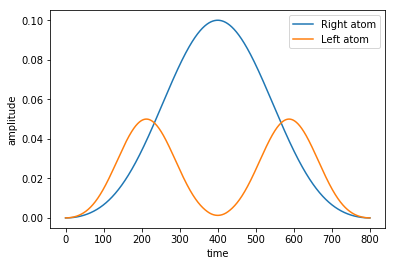

In [10]:
fig, ax = plt.subplots()
ax.plot(tlist, right_atom_pulse(t_start,t_stop)(tlist,None),label='Right atom')
ax.plot(tlist,  left_atom_pulse(t_start,t_stop)(tlist,None),label='Left atom' )
plt.legend()
ax.set_xlabel('time')
ax.set_ylabel('amplitude')
plt.show()

After defining the pulses we add the pulses to the respective Hamiltonian

In [12]:
Ham[1][1] =  left_atom_pulse(t_start,t_stop) #  left atom blue
Ham[2][1] =  left_atom_pulse(t_start,t_stop) #  left atom red
Ham[3][1] = right_atom_pulse(t_start,t_stop) # right atom blue
Ham[4][1] = right_atom_pulse(t_start,t_stop) # right atom red

In [13]:
Ham[1][1] =  left_atom_pulse(t_start,t_stop, ampl=.1475, pi_duration=50) #  left atom blue
Ham[2][1] =  left_atom_pulse(t_start,t_stop, ampl=.1475, pi_duration=50) #  left atom red
Ham[3][1] = right_atom_pulse(t_start,t_stop, ampl=.055) # right atom blue
Ham[4][1] = right_atom_pulse(t_start,t_stop, ampl=.055) # right atom red

*Again: Note, that the function calls return function objects in this case!*

### Taking into account the gate

Before we can start, we need to specify the basis states, on which the gate should act. These are given by $\big\{\ket{00}$, $\ket{01}$, $\ket{10}$, $\ket{11}\big\}$. 

In [14]:
basis_states = [qutip.tensor(A,B) for A,B in itertools.product([qb_ground,qb_excited],repeat=2)]
basis_proj   = [bs*bs.dag() for bs in basis_states]

Using krotov's `gate_objectives` function, we get the objectives for the gate, which returns a list of the four objectives.

In [15]:
objectives = krotov.gate_objectives(
    basis_states=basis_states, gate=O, H=Ham)

In [16]:
krotov.objectives.summarize_qobj(Ham)

'[Herm[4⊗4,4⊗4], [Herm[4⊗4,4⊗4], u1(t)], [Herm[4⊗4,4⊗4], u2(t)], [Herm[4⊗4,4⊗4], u3(t)], [Herm[4⊗4,4⊗4], u4(t)]]'

In [17]:
len(objectives)

4

### Pulse options

In addition to the objectives, we need to specify the `pulse_options` for each of the control Hamiltonians.
For the shape of the pulses, we choose the guess pulse.

In [18]:
lambda_11 = lambda_21 = lambda_31 = lambda_41 = .25


pulse_options = {
    Ham[1][1]: dict(lambda_a=lambda_11, shape=lambda t: Ham[1][1](t,None)/np.amax(Ham[1][1](tlist,None))),
    Ham[2][1]: dict(lambda_a=lambda_21, shape=lambda t: Ham[2][1](t,None)/np.amax(Ham[2][1](tlist,None))),
    Ham[3][1]: dict(lambda_a=lambda_31, shape=lambda t: Ham[3][1](t,None)/np.amax(Ham[3][1](tlist,None))),
    Ham[4][1]: dict(lambda_a=lambda_41, shape=lambda t: Ham[4][1](t,None)/np.amax(Ham[4][1](tlist,None))),
    }


In addition to that, we also specify a function, which we can add as 'info_hook' in the optimize function. This allows us to see the fidelity after each iteration.

In [19]:
def print_fidelity(**args): 
    F_re = np.average(np.array(args['tau_vals']).real)
    print("Iteration {:d}: \tF = {:f}".format(args['iteration'], F_re))
    return F_re

### Simulate the dynamics of the guess pulse

To get an overview of the dynamics, we again plot the pulses ...

In [20]:
def plot_pulse(pulse, tlist):
    fig, ax = plt.subplots()
    if callable(pulse):
        pulse = np.array([pulse(t, None) for t in tlist])
    ax.plot(tlist, pulse)
    ax.set_xlabel('time')
    ax.set_ylabel('pulse amplitude')
    plt.show(fig)

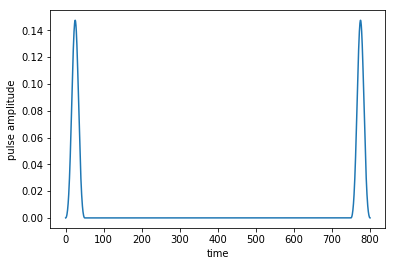

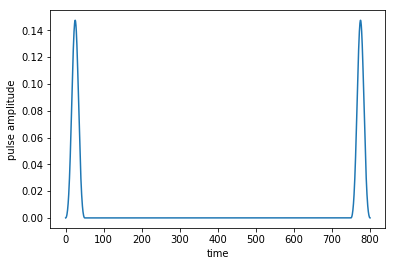

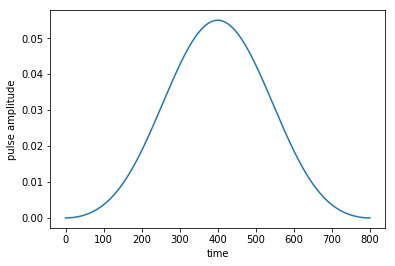

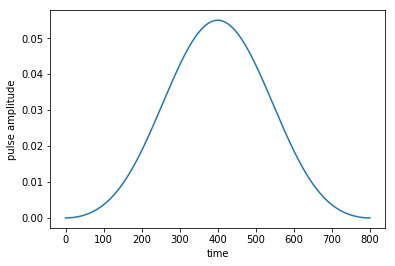

In [21]:
plot_pulse(Ham[1][1], tlist)
plot_pulse(Ham[2][1], tlist)
plot_pulse(Ham[3][1], tlist)
plot_pulse(Ham[4][1], tlist)

... and obtain the dynamics for the guess pulses by using qutip's mesolve routine.

In [24]:
guess_dynamics = [objctv.mesolve(tlist, e_ops=basis_proj) for objctv in objectives] 

In [23]:
def plot_population(results):
    fig, axs = plt.subplots(2,2)
    for idx,ax in enumerate(axs.flatten()):
        ax.plot(results[idx].times, results[idx].expect[0], label='00')
        ax.plot(results[idx].times, results[idx].expect[1], label='01')
        ax.plot(results[idx].times, results[idx].expect[2], label='10')
        ax.plot(results[idx].times, results[idx].expect[3], label='11')
        ax.legend()
        ax.set_xlabel('time')
        ax.set_ylabel('population')
    plt.show(fig)

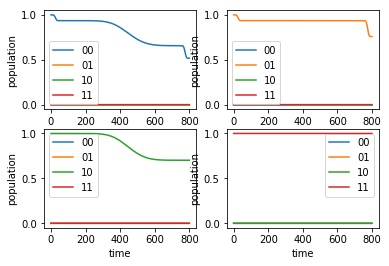

In [25]:
plot_population(guess_dynamics)

### Optimize

With everything set up properly, we can now start the optimization of the pulses by invoking krotov's `optimize_pulses` routine.

In [24]:
%%time
# This takes some time
oct_result = krotov.optimize_pulses(
    objectives, pulse_options, tlist,
    propagator=krotov.propagators.expm,
    chi_constructor=krotov.functionals.chis_re,
    info_hook=print_fidelity, iter_stop=30
    )

Iteration 0: 	F = -0.016712
Iteration 1: 	F = 0.490407
Iteration 2: 	F = 0.653577
Iteration 3: 	F = 0.688633
Iteration 4: 	F = 0.707792
Iteration 5: 	F = 0.724785
Iteration 6: 	F = 0.744309
Iteration 7: 	F = 0.771054
Iteration 8: 	F = 0.796112
Iteration 9: 	F = 0.811290
Iteration 10: 	F = 0.817151
Iteration 11: 	F = 0.819278
Iteration 12: 	F = 0.820213
Iteration 13: 	F = 0.820675
Iteration 14: 	F = 0.820917
Iteration 15: 	F = 0.821048
Iteration 16: 	F = 0.821119
Iteration 17: 	F = 0.821159
Iteration 18: 	F = 0.821182
Iteration 19: 	F = 0.821194
Iteration 20: 	F = 0.821201
Iteration 21: 	F = 0.821206
Iteration 22: 	F = 0.821208
Iteration 23: 	F = 0.821209
Iteration 24: 	F = 0.821210
Iteration 25: 	F = 0.821211
Iteration 26: 	F = 0.821211
Iteration 27: 	F = 0.821211
Iteration 28: 	F = 0.821212
Iteration 29: 	F = 0.821212
Iteration 30: 	F = 0.821212
CPU times: user 22min 23s, sys: 1.42 s, total: 22min 24s
Wall time: 22min 24s


In [ ]:
%%time
# This does not work!
prop = krotov.propagators.StateHamODEPropagator()
oct_result = krotov.optimize_pulses(
    objectives, pulse_options, tlist,
    propagator=prop,
    chi_constructor=krotov.functionals.chis_re,
    info_hook=print_fidelity, iter_stop=3,
    parallel_map=qutip.parallel.serial_map,
    )

--------

<div class="alert alert-block alert-warning">
From here on it is just some testing and preliminary stuff
</div>

--------

In [ ]:
#oct_result = krotov.result.Result().load("ensemble_results/res.krotov")

After the optimization has finished, we can have a look on the optimized control pulses ...

In [ ]:
plot_pulse(oct_result.optimized_controls[0], tlist)
plot_pulse(oct_result.optimized_controls[1], tlist)
plot_pulse(oct_result.optimized_controls[2], tlist)
plot_pulse(oct_result.optimized_controls[3], tlist)

... and verify the results

In [ ]:
opt_dynamics = [opt_objctv.mesolve( tlist, e_ops=basis_proj) for opt_objctv in oct_result.optimized_objectives]

In [ ]:
plot_population(opt_dynamics)

In [ ]:
[basis_states[i].dag()*oct_result.states[i] for i in range(4)]

In [ ]:
oct_result.tau_vals[-1]

## Optimization *with* ensembles

Now, that we have seen, that we are able to optimize our system with the given Hamiltonian, we want to make it more robust with respect to fluctuations in the pulse amplitude and the Rydberg level.
For this we choose an ensemble with N=9 Hamiltonians, each sampling the values of $\Delta_{\mathrm{ryd}}= \pm 300\mathrm{kHz}$ and the the dipole coupling strength $\pm 5\%$ 

###  Getting the ensemble of Hamiltonians

Now we do exactly the same thing as [above](#Optimization-without-ensembles), but we vary the parameters of $\Delta_{\mathrm{ryd}}$ and the dipole coupling strength. The resulting Hamiltonians (`ensemble_hamiltonian`) and the corresponding pulse options are stored in a list and dictionary, respectively.

In [ ]:
ham_ensemble=[]
pulse_option_ensemble = pulse_options.copy()

for Δryd in [-.3e-3,0,.3e-3]:
    for dipl_coupl_str_factor in [.95,1.,1.05]:
        # continue if no variation present
        if Δryd == 0 and dipl_coupl_str_factor==1:
            continue
            
        ensemble_hamiltonian = \
            get_ham_2q(rabi_freq_blue=dipl_coupl_str_factor*rabi_freq_blue,
                       rabi_freq_red =dipl_coupl_str_factor*rabi_freq_red, 
                       diag=[0,e1,delta_1,delta_2+Δryd])
        
        #adding pulse options for the whole ensemble
        ensemble_hamiltonian[1][1] = Ham[1][1] #  left atom blue
        ensemble_hamiltonian[2][1] = Ham[2][1] #  left atom red
        ensemble_hamiltonian[3][1] = Ham[3][1] # right atom blue
        ensemble_hamiltonian[4][1] = Ham[4][1] # right atom red
        
        pulse_option_ensemble.update(
         {  ensemble_hamiltonian[1][1]: krotov.PulseOptions(
                            lambda_a=lambda_11, 
                            shape=lambda t: (ensemble_hamiltonian[1][1](t,None)
                                             /np.amax(ensemble_hamiltonian[1][1](tlist,None))),
            ensemble_hamiltonian[2][1]: krotov.PulseOptions(
                            lambda_a=lambda_21, 
                            shape=lambda t: (ensemble_hamiltonian[2][1](t,None)
                                             /np.amax(ensemble_hamiltonian[2][1](tlist,None))),
            ensemble_hamiltonian[3][1]: krotov.PulseOptions(
                            lambda_a=lambda_31, 
                            shape=lambda t: (ensemble_hamiltonian[3][1](t,None)
                                             /np.amax(ensemble_hamiltonian[3][1](tlist,None))),
            ensemble_hamiltonian[4][1]: krotov.PulseOptions(
                            lambda_a=lambda_41, 
                            shape=lambda t: (ensemble_hamiltonian[4][1](t,None)
                                             /np.amax(ensemble_hamiltonian[4][1](tlist,None))),
          })
                
        ham_ensemble.append(ensemble_hamiltonian)


Finally, we can create the ensemble objectives by using the `ensemble_objectives` routine of the krotov package...

In [ ]:
ensemble_objectives = krotov.objectives.ensemble_objectives(objectives, ham_ensemble)

... to optimize the pulses with them, as we did before

In [ ]:
%%time
oct_result_ensemble = krotov.optimize_pulses(
    ensemble_objectives, pulse_option_ensemble, tlist,
    propagator=krotov.propagators.expm,
    chi_constructor=krotov.functionals.chis_re,
    info_hook=print_fidelity, iter_stop=4
    )

In [ ]:
plot_pulse(oct_result_ensemble.optimized_controls[0], tlist)
plot_pulse(oct_result_ensemble.optimized_controls[1], tlist)
plot_pulse(oct_result_ensemble.optimized_controls[2], tlist)
plot_pulse(oct_result_ensemble.optimized_controls[3], tlist)